<div class="span5 alert alert-info">
Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period , identify which factors predict future user adoption.  

    
We suggest spending 12 hours on this, but you're welcome to spend more or less. Please send us a brief writeup of your findings (the more concise, the better no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.
</div>

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [221]:
# import user data (to create features)
users = pd.read_csv('relax_challenge/takehome_users.csv', encoding = "ISO-8859-1")
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [222]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


last_session_creation_time and invited_by_user_id have missing values.

In [223]:
# import user engagement data (to create target)
engage = pd.read_csv('relax_challenge/takehome_user_engagement.csv')
engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [224]:
engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


### Data Cleaning/Wrangling

In [225]:
# convert date to datetime in engage
engage['time_stamp'] = pd.to_datetime(engage['time_stamp'])
engage['time_stamp'] = engage['time_stamp'].dt.week
engage['time_stamp'].head()

0    17
1    46
2    48
3    50
4    52
Name: time_stamp, dtype: int64

In [226]:
# calculate target
engage = engage.groupby(['time_stamp', 'user_id']).sum().groupby('user_id').max()
engage['visited'] = np.where(engage['visited']>=3, 1, 0)

In [227]:
engage.reset_index(inplace=True)
engage.head()

,user_id,visited
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


In [228]:
# join calculated target variable to users

users = users.merge(engage,how='left',left_on='object_id',right_on='user_id')

In [229]:
# fill missing values in users for target as 0
users['visited'].fillna(0, inplace=True)

# drop user id
users.drop(['object_id','user_id'], axis=1, inplace=True)

In [230]:
# change invited_by_user_id to a dummy, where if invited=1, else=0 <-- also takes care of missing values
users['invited_by_user_id'] = np.where(users['invited_by_user_id'].isna(), 0, 1)

In [231]:
# fillna as creation_time for last_session_creation_time

users['creation_time'] = pd.to_datetime(users['creation_time']).astype(int) / 10**9
users['last_session_creation_time'].fillna(users['creation_time'], inplace=True)

In [232]:
users.describe()

,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited
count,1.200000e+04,1.200000e+04,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,1.373981e+09,1.377743e+09,0.249500,0.149333,141.884583,0.534750,0.120417
std,1.871814e+07,1.952576e+07,0.432742,0.356432,124.056723,0.498812,0.325462
min,1.338425e+09,1.338452e+09,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.358285e+09,1.361464e+09,0.000000,0.000000,29.000000,0.000000,0.000000
50%,1.375739e+09,1.380630e+09,0.000000,0.000000,108.000000,1.000000,0.000000
75%,1.390904e+09,1.396570e+09,0.000000,0.000000,238.250000,1.000000,0.000000
max,1.401494e+09,1.402067e+09,1.000000,1.000000,416.000000,1.000000,1.000000


In [233]:
# change email to email server
users['email'] = users['email'].str.extract(r'[@](.*)[.]')
users['email'].head()

0    yahoo
1    gustr
2    gustr
3    yahoo
4    yahoo
Name: email, dtype: object

In [234]:
users['email'].value_counts()[:20]

gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
gustr         1179
hotmail       1165
oqpze            2
qgjbc            2
xvnbr            2
mumdc            2
xybhi            2
luque            2
dqwln            2
rerwl            2
egruv            1
fizyt            1
yqkbx            1
zsrgb            1
dmbrh            1
mgtbx            1
Name: email, dtype: int64

In [235]:
# apart from the top 6 emails, set as 'other'
top_emails = list(users['email'].unique()[:6])
print(top_emails)

users['email'] = np.where(users["email"].isin(top_emails), users['email'], 'Other')
users['email'].value_counts()

['yahoo', 'gustr', 'jourrapide', 'hotmail', 'cuvox', 'gmail']


gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
Other         1186
gustr         1179
hotmail       1165
Name: email, dtype: int64

In [236]:
from sklearn.preprocessing import LabelEncoder

In [237]:
cat_var = ['email', 'creation_source', 'org_id']
for cat in cat_var:
    print(cat, len(users[cat].unique()))

email 7
creation_source 5
org_id 417


In [238]:
users = pd.get_dummies(users, columns=['email', 'creation_source'])

le = LabelEncoder()
users['org_id'] = le.fit_transform(users[cat].values)

In [239]:
print(users.shape)
users.head()

(12000, 20)


,creation_time,name,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited,email_Other,email_cuvox,email_gmail,email_gustr,email_hotmail,email_jourrapide,email_yahoo,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1.398139e+09,Clausen August,1.398139e+09,1,0,11,1,0.0,0,0,0,0,0,0,1,1,0,0,0,0
1,1.384487e+09,Poole Matthew,1.396238e+09,0,0,1,1,1.0,0,0,0,1,0,0,0,0,1,0,0,0
2,1.363735e+09,Bottrill Mitchell,1.363735e+09,0,0,94,1,0.0,0,0,0,1,0,0,0,0,1,0,0,0
3,1.369124e+09,Clausen Nicklas,1.369210e+09,0,0,1,1,0.0,0,0,0,0,0,0,1,1,0,0,0,0
4,1.358418e+09,Raw Grace,1.358850e+09,0,0,193,1,0.0,0,0,0,0,0,0,1,1,0,0,0,0


I used label encoder vs one-hot encoding for org_id because using one-hot encoding would lead to a huge number of features

In [240]:
# drop name

users.drop('name', axis=1, inplace=True)

In [241]:
users.columns

Index(['creation_time', 'last_session_creation_time',
       'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'visited', 'email_Other', 'email_cuvox',
       'email_gmail', 'email_gustr', 'email_hotmail', 'email_jourrapide',
       'email_yahoo', 'creation_source_GUEST_INVITE',
       'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',
       'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH'],
      dtype='object')

### EDA

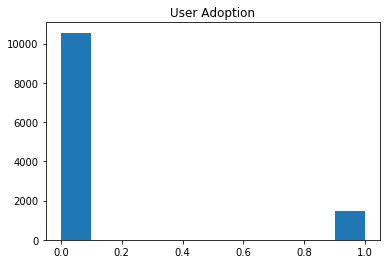

In [209]:
plt.hist(users['visited'])
plt.title('User Adoption')
plt.show()

In [212]:
len(users[users['visited']==1])/len(users)

0.12041666666666667

The data is very imbalanced, with the majority of users never having logged in at least 3 times in one week. Only 12.04% of users are 'adopted users'.

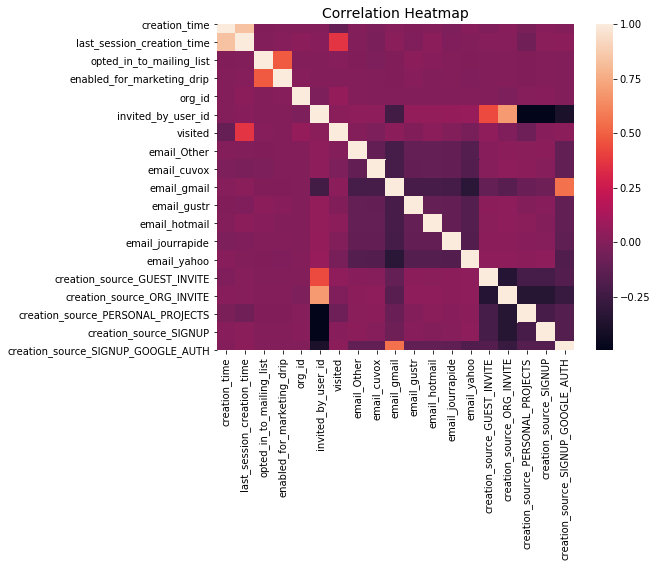

In [203]:
corr = users.corr()

plt.subplots(figsize=(8, 6))
sns.heatmap(corr)
plt.title('Correlation Heatmap', size=14);

In [207]:
len(users[users['creation_time']==users['last_session_creation_time']])/len(users)

0.517

In [208]:
corr['visited'].sort_values()

creation_time                        -0.098312
creation_source_PERSONAL_PROJECTS    -0.072093
email_yahoo                          -0.038551
email_cuvox                          -0.019395
creation_source_ORG_INVITE           -0.011376
email_gustr                          -0.010298
email_jourrapide                     -0.000505
email_Other                           0.004449
enabled_for_marketing_drip            0.005901
opted_in_to_mailing_list              0.010339
creation_source_SIGNUP                0.016004
invited_by_user_id                    0.022735
email_gmail                           0.028066
creation_source_SIGNUP_GOOGLE_AUTH    0.031432
email_hotmail                         0.035212
creation_source_GUEST_INVITE          0.043657
org_id                                0.060683
last_session_creation_time            0.366307
visited                               1.000000
Name: visited, dtype: float64

creation_time and last_session_creation_time are highly positively correlated, which means a large portion of users never logged in after initially creating an id. Specifically, 51.7% of users, more than half, never logged in after creating an id. last_session_creation_time is the most corrrelated with user adoption (visted). 

### Feature Importance using RF tree

In [242]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [248]:
y = users['visited']
X = users.drop('visited', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [249]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

/Users/meiliu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [250]:
importance = rf.feature_importances_
features = list(users.drop('visited', axis=1).columns)
important_features = pd.Series(importance, index=features)

important_features.sort_values(ascending=False)

last_session_creation_time            0.662536
creation_time                         0.234670
org_id                                0.059125
opted_in_to_mailing_list              0.005831
enabled_for_marketing_drip            0.004429
creation_source_GUEST_INVITE          0.003361
creation_source_PERSONAL_PROJECTS     0.003085
email_gmail                           0.002902
email_yahoo                           0.002877
email_gustr                           0.002812
creation_source_ORG_INVITE            0.002795
email_jourrapide                      0.002718
invited_by_user_id                    0.002467
email_hotmail                         0.002438
email_Other                           0.002325
email_cuvox                           0.002165
creation_source_SIGNUP                0.001777
creation_source_SIGNUP_GOOGLE_AUTH    0.001688
dtype: float64

The 3 most important features in the RF model are last_session_creation_time, creation_time, and org_id.

Additional things to try: 
- Permutation feature importance
- Drop Column feature importance